In [5]:
# importing libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score, 
    HalvingGridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix
)
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier

from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# library list: matplotlib, numpy, pandas, scikit-learn, fairlearn, tensorflow


# 1. Dataset processing

1.1 Preparing the individual panel datasets

In [6]:
# loading in all the panels in label

background = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/1. Background variables/background_variables.csv', sep = ';',index_col='nomem_encr')
health = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/2. Health/health.csv', sep = ';',index_col='nomem_encr')
religion = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/3. Religion, ethnicity /religion_ethnicity.csv', sep = ';',index_col='nomem_encr')
social = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/4. Social, leisure /social_integration_leisure.csv', sep = ';',index_col='nomem_encr')
politics = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/8. Politics and values/politics_values.csv', sep = ';',index_col='nomem_encr')
assets = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/9. Assets/assets.csv', sep = ';',index_col='nomem_encr')


/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/4277617804.py:4: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  health = pd.read_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/2. Health/health.csv', sep = ';',index_col='nomem_encr')


1.2 imputation of missing values

In [7]:
# Compiling a list of relevant features per panel

# first create a list of all the relevant features selected per dataframe
# this will be used to easily select the relevant features for processing

# Separate lists for each category of variables

background_variables = ['herkomstgroep', 'burgstat', 'woonvorm', 'positie', 'aantalhh', 'aantalki', 'brutoink', 'nettoink', 'brutocat', 'nettocat', 'oplmet', 'oplzon', 'belbezig', 'woning']
health_variables = ['ch24q159', 'ch24q160', 'ch24q161', 'ch24q162', 'ch24q163', 'ch24q270', 'ch24q004', 'ch24q011', 'ch24q012', 'ch24q013', 'ch24q014', 'ch24q015', 'ch24q018', 'ch24q125', 'ch24q130', 'ch24q133', 'ch24q135', 'ch24q164', 'ch24q165', 'ch24q166', 'ch24q167', 'ch24q168', 'ch24q271', 'ch24q023', 'ch24q024', 'ch24q025', 'ch24q026', 'ch24q027', 'ch24q028', 'ch24q029', 'ch24q030', 'ch24q031', 'ch24q034', 'ch24q044']
religion_variables = ['cr24q143','cr24q164', 'cr24q165', 'cr24q166', 'cr24q167', 'cr24q168', 'cr24q169', 'cr24q170', 'cr24q171', 'cr24q172', 'cr24q173', 'cr24q174', 'cr24q175', 'cr24q176', 'cr24q177', 'cr24q178', 'cr24q179', 'cr24q181', 'cr24q079', 'cr24q080', 'cr24q081', 'cr24q082', 'cr24q083', 'cr24q084', 'cr24q085', 'cr24q086', 'cr24q087', 'cr24q097', 'cr24q098']
social_variables = ['cs24q634', 'cs24q635', 'cs24q636', 'cs24q290', 'cs24q291', 'cs24q292', 'cs24q005', 'cs24q006', 'cs24q010', 'cs24q011', 'cs24q015', 'cs24q016', 'cs24q020', 'cs24q021', 'cs24q025', 'cs24q026', 'cs24q030', 'cs24q031', 'cs24q035', 'cs24q036', 'cs24q040', 
                    'cs24q041', 'cs24q045', 'cs24q046', 'cs24q050', 'cs24q051', 'cs24q055', 'cs24q056', 'cs24q060', 'cs24q061', 'cs24q065', 'cs24q066', 'cs24q284', 'cs24q285', 'cs24q286', 'cs24q287', 'cs24q288', 'cs24q289', 'cs24q063', 'cs24q064', 'cs24q065', 'cs24q007', 'cs24q012', 'cs24q017', 'cs24q022', 'cs24q027', 'cs24q032', 'cs24q037', 'cs24q042', 'cs24q047', 
                    'cs24q052', 'cs24q057', 'cs24q062', 'cs24q067', 'cs24q104', 'cs24q160', 'cs24q161', 'cs24q162', 'cs24q164', 'cs24q165', 'cs24q166', 'cs24q167', 'cs24q169', 'cs24q171', 'cs24q172', 'cs24q173', 'cs24q174', 'cs24q175', 'cs24q176', 'cs24q177', 'cs24q178', 'cs24q179', 'cs24q180', 'cs24q181', 'cs24q182', 'cs24q183', 'cs24q184', 'cs24q185', 'cs24q186', 
                    'cs24q187', 'cs24q188', 'cs24q189', 'cs24q190', 'cs24q191', 'cs24q192', 'cs24q195', 'cs24q196', 'cs24q197', 'cs24q198', 'cs24q199', 'cs24q200', 'cs24q201', 'cs24q202', 'cs24q205', 'cs24q206', 'cs24q209', 'cs24q210', 'cs24q211', 'cs24q212', 'cs24q213', 'cs24q214', 'cs24q215', 'cs24q216', 'cs24q217', 'cs24q218', 'cs24q219', 'cs24q220', 'cs24q221', 
                    'cs24q222', 'cs24q223', 'cs24q224', 'cs24q225', 'cs24q226', 'cs24q227', 'cs24q228', 'cs24q229', 'cs24q230', 'cs24q231', 'cs24q232', 'cs24q233', 'cs24q234', 'cs24q235', 'cs24q236', 'cs24q237', 'cs24q238', 'cs24q239', 'cs24q240']
politics_variables = ['cv25q013', 'cv25q014', 'cv25q015', 'cv25q016', 'cv25q017', 'cv25q018', 'cv25q019', 'cv25q020', 'cv25q021', 'cv25q022', 'cv25q023', 'cv25q024', 'cv25q025', 'cv25q026', 'cv25q027']
assets_variables = ['ca22h078', 'ca22h005', 'ca22h006', 'ca22h007', 'ca22h008', 'ca22h010', 'ca22h011', 'ca22h056', 'ca22h060', 'ca22h012', 'ca22h013', 'ca22h014', 'ca22h015', 'ca22h016', 'ca22h017',
                     'ca22h018', 'ca22h019', 'ca22h023', 'ca22h024', 'ca22h025', 'ca22h026', 'ca22h027', 'ca22h028', 'ca22h034', 'ca22h035', 'ca22h055', 'ca22h083', 'ca22h085', 'ca22h063', 'ca22h020', 'ca22h054', 'ca22h057', 'ca22h058', 'ca22h069', 'ca22h065', 'ca22h066']

# Create a dictionary to hold all the variable lists
variables_dict = {
    'background': background_variables,
    'health': health_variables,
    'religion': religion_variables,
    'social': social_variables,
    'politics': politics_variables,
    'assets': assets_variables
}

# Create a ditionary to hold all the dataframes
dataframes_dict = {
    'background': background,
    'health': health,
    'religion': religion,
    'social': social,
    'politics': politics,
    'assets': assets
}

In [8]:
# Preparing the variables for imputation

# checking the missing values per feature in the list created in the cell above
# missing values in this dataset are either NaN, '', or any negative value
# first the negative values and '' have to be changed to a missing value except for herkomstgroep
# Convert columns to numeric, coercing errors to NaN
for category, df in dataframes_dict.items():
    dataframes_dict[category] = df.apply(pd.to_numeric, errors='coerce')

# Replace all negative values and '' with NaN
for category, df in dataframes_dict.items():
    dataframes_dict[category] = df.applymap(lambda x: np.nan if (isinstance(x, (int, float)) and x < 0) or x == '' else x)

# Create a dataframe to summarize the missing values per feature based on variables_dict and dataframes_dict
missing_values_summary = pd.DataFrame([
    {
        'Feature': feature,
        'Missing Values': dataframes_dict[category][feature].isnull().sum()
    }
    for category, features in variables_dict.items()
    for feature in features if feature in dataframes_dict[category].columns
])

# Display the dataframe
print(missing_values_summary)
# there are many conditional questions that logically lead to missing data if the condition is not met 
# these do not need to be imputed since they are conditional
# the conditional variables missing values can be set to 0, as for consequential feature construction the missing of value will be taken into account in an gated structure. 
# after manual control of the codebooks and missing values, all variables that have more than 100 missing values are ruled to be conditional, with the exception of 'herkomstgroep' 
# first, the missing values will all be set to 0 for the conditional variables mentioned with more than 100 missing values (except for 'herkomstgroep')

# Identify conditional variables with more than 102 missing values, excluding 'herkomstgroep'
conditional_variables = missing_values_summary[
    (missing_values_summary['Missing Values'] > 102) & 
    (missing_values_summary['Feature'] != 'herkomstgroep')
]['Feature'].tolist()
print(dataframes_dict['religion']['cr24q143'].unique())
# Set missing values to 0 for these conditional variables
for category, features in variables_dict.items():
    for feature in features:
        if feature in conditional_variables and feature in dataframes_dict[category].columns:
            dataframes_dict[category][feature].fillna(0, inplace=True)

# update the missing values summary after setting the conditional variables to 0
missing_values_summary = pd.DataFrame([
    {
        'Feature': feature,
        'Missing Values': dataframes_dict[category][feature].isnull().sum()
    }
    for category, features in variables_dict.items()
    for feature in features if feature in dataframes_dict[category].columns
])
print(missing_values_summary)

/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/3562812181.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict[category] = df.applymap(lambda x: np.nan if (isinstance(x, (int, float)) and x < 0) or x == '' else x)


           Feature  Missing Values
0    herkomstgroep            3337
1         burgstat               0
2         woonvorm               0
3          positie               0
4         aantalhh               0
..             ...             ...
250       ca22h057              30
251       ca22h058              30
252       ca22h069              30
253       ca22h065            5167
254       ca22h066              30

[255 rows x 2 columns]
[ 1.  2. nan]
           Feature  Missing Values
0    herkomstgroep            3337
1         burgstat               0
2         woonvorm               0
3          positie               0
4         aantalhh               0
..             ...             ...
250       ca22h057              30
251       ca22h058              30
252       ca22h069              30
253       ca22h065               0
254       ca22h066              30

[255 rows x 2 columns]


/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/3562812181.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframes_dict[category][feature].fillna(0, inplace=True)


In [9]:
# the rest of the features with missing values will now be imputed (not herkomstgroep) 
# Impute the remaining features with missing values that are not conditional and not 'herkomstgroep'
# Using IterativeImputer for imputation

# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=0)

# Iterate through each category in variables_dict
for category, features in variables_dict.items():
    for feature in features:
        if feature not in conditional_variables and feature != 'herkomstgroep' and feature in dataframes_dict[category].columns:
            # Reshape the data for imputation
            data = dataframes_dict[category][feature].values.reshape(-1, 1)
            # Perform imputation
            dataframes_dict[category][feature] = imputer.fit_transform(data).ravel()


# check again for missing values
missing_values_summary = pd.DataFrame([
    {
        'Feature': feature,
        'Missing Values': dataframes_dict[category][feature].isnull().sum()
    }
    for category, features in variables_dict.items()
    for feature in features if feature in dataframes_dict[category].columns
])
# Display the updated dataframe
print(missing_values_summary)


           Feature  Missing Values
0    herkomstgroep            3337
1         burgstat               0
2         woonvorm               0
3          positie               0
4         aantalhh               0
..             ...             ...
250       ca22h057               0
251       ca22h058               0
252       ca22h069               0
253       ca22h065               0
254       ca22h066               0

[255 rows x 2 columns]


The features that will be used to craft the dataset now all have been imputed while still in their original panel dataset, making sure that the imputation has maximum accuracy and the least data loss. 

1.3 Creating the features in the baseline dataset and health-enriched dataset

In [10]:
# Creating the features

# all features that are added are concatenated on the index. if the index number is not in both the baseline dataset and the new feature, the row is dropped
# the first feature is excluded from this practice since the dataframe is not yet created
#copying the background dataset to a new dataframe to create a new dataset with the index included
baseline_dataset = dataframes_dict['background'].copy()

#dropping all the variables from baseline_dataset so we are left with only the complete index for all the participants
#this way, we are sure that we do not miss any participants that might not have parctipated in the other panels
#we will drop all the rows that are not complete at completion
baseline_dataset = baseline_dataset.iloc[:, 0:0]
print(baseline_dataset.head())

# now we will add the features to the baseline dataset
# religious yes/no 
# based on cr24q143
# input is 1 = yes, 2 = no
# output is a binary variable, 1 if the person is religious, 0 if not
# this will be added to the baseline_dataset
# Create a binary variable in baseline_dataset based on cr24q143
# only join the rows where the index is in both dataframes
# Adding a binary feature for being religious based on cr24q143
baseline_dataset = baseline_dataset.join(
    dataframes_dict['religion'][['cr24q143']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'cr24q143': 'religious'}),
    how='inner'
) 
# Add the rest of the features to the baseline dataset in the same fashion

# ethnical connection
# based on cr24q164, cr24q165, cr24q166, cr24q167, cr24q168, cr24q169, cr24q170, cr24q171, cr24q172, cr24q173, cr24q174, cr24q175, cr24q176, cr24q177, cr24q178, cr24q179, cr24q181
# input is (cr24q164) +  (cr24q181 * any of the other variables (binary yes/no 1/0))
# join the rows where the index is in both dataframes
# Create a list of other variables to be used in the computation
other_variables = [
    'cr24q165', 'cr24q166', 'cr24q167', 'cr24q168', 'cr24q169', 
    'cr24q170', 'cr24q171', 'cr24q172', 'cr24q173', 'cr24q174', 
    'cr24q175', 'cr24q176', 'cr24q177', 'cr24q178', 'cr24q179'
]

print(dataframes_dict['religion']['cr24q164'].unique())
print(dataframes_dict['religion']['cr24q181'].unique())

# Compute the ethnical connection score
baseline_dataset = baseline_dataset.join(
    (dataframes_dict['religion']['cr24q164'] + 
     (dataframes_dict['religion']['cr24q181'] * dataframes_dict['religion'][other_variables].sum(axis=1))).rename('ethical_connection'),
    how='inner'
)

# regular interaction count
# based on cs24q634, cs24q635, cs24q636, cs24q290, cs24q291, cs24q292
# sum the values of these variables
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['social'][['cs24q634', 'cs24q635', 'cs24q636', 'cs24q290', 'cs24q291', 'cs24q292']].sum(axis=1).rename('regular_interaction_count'),
    how='inner'
)

# group participation
# based on cs24q005, cs24q010, cs24q015, cs24q020, cs24q025, cs24q030, cs24q035, cs24q040, cs24q045, cs24q050, cs24q055, cs24q060, cs24q525 
# for each variable, if the value is 1, add 1 to the count of the variable
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['social'][['cs24q005', 'cs24q010', 'cs24q015', 'cs24q020', 'cs24q025', 'cs24q030', 'cs24q035', 'cs24q040', 'cs24q045', 'cs24q050', 'cs24q055', 'cs24q060']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1).rename('group_participation'),
    how='inner'
)

# loneliness
# based on cs24q284, cs24q285, cs24q286, cs24q287, cs24q288, cs24q289
# sum the values of these variables
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['social'][['cs24q284', 'cs24q285', 'cs24q286', 'cs24q287', 'cs24q288', 'cs24q289']].sum(axis=1).rename('loneliness'),
    how='inner'
)

# number of household members
# based on aantalhh
# add the value to the baseline dataset
baseline_dataset = baseline_dataset.join(
    dataframes_dict['background'][['aantalhh']].rename(columns={'aantalhh': 'number_of_household_members'}),
    how='inner'
)

# confidence in politics
# based on cv25q013, cv25q014, cv25q015, cv25q016, cv25q017, cv25q018, cv25q019, cv25q020, cv25q021
# average of these values is the new value
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['politics'][['cv25q013', 'cv25q014', 'cv25q015', 'cv25q016', 'cv25q017', 'cv25q018', 'cv25q019', 'cv25q020', 'cv25q021']].mean(axis=1).rename('confidence_in_politics'),
    how='inner'
)

# language proficiency
# based on cr24q079, cr24q080, cr24q081, cr24q082, cr24q083, cr24q084, cr24q085, cr24q086, cr24q087
# sum the values of these variables
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['religion'][['cr24q079', 'cr24q080', 'cr24q081', 'cr24q082', 'cr24q083', 'cr24q084', 'cr24q085', 'cr24q086', 'cr24q087']].sum(axis=1).rename('language_proficiency'),
    how='inner'
) 

# informal caregiving
# based on cs24q063
# 1 = yes, 2 = no, output is 1 = yes, 0 = no
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['social'][['cs24q063']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'cs24q063': 'informal_caregiving'}),
    how='inner'
)

# volunteer work
# based on cs24q007, cs24q012, cs24q017, cs24q022, cs24q027, cs24q032, cs24q037, cs24q042, cs24q047, cs24q052, cs24q057, cs24q062, cs24q527
# for each variable, if the value is 1, add 1 to the count of the variable
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['social'][['cs24q007', 'cs24q012', 'cs24q017', 'cs24q022', 'cs24q027', 'cs24q032', 'cs24q037', 'cs24q042', 'cs24q047', 'cs24q052', 'cs24q057', 'cs24q062']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1).rename('volunteer_work'),
    how='inner'
)

# income
# based on nettocat
# add the value to the baseline dataset
baseline_dataset = baseline_dataset.join(
    dataframes_dict['background'][['nettocat']].rename(columns={'nettocat': 'income'}),
    how='inner'
)

# education
# based on oplmet
# add the value to the baseline dataset
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['background'][['oplmet']].rename(columns={'oplmet': 'education'}),
    how='inner'
)

# employment status
# based on belbezig
# add the value to the baseline dataset
baseline_dataset = baseline_dataset.join(
    dataframes_dict['background'][['belbezig']].rename(columns={'belbezig': 'employment_status'}),
    how='inner'
)

# housing 
# based on woning
# add the value to the baseline dataset
# join the rows where the index is in both dataframes
baseline_dataset = baseline_dataset.join(
    dataframes_dict['background'][['woning']].rename(columns={'woning': 'housing'}),
    how='inner'
)

print(baseline_dataset.head())



Empty DataFrame
Columns: []
Index: [800001, 800002, 800009, 800015, 800028]
[2.         3.         1.         4.         1.68839681]
[0. 1. 2. 3. 4.]


/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/1096052581.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['religion'][['cr24q143']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'cr24q143': 'religious'}),
/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/1096052581.py:64: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['social'][['cs24q005', 'cs24q010', 'cs24q015', 'cs24q020', 'cs24q025', 'cs24q030', 'cs24q035', 'cs24q040', 'cs24q045', 'cs24q050', 'cs24q055', 'cs24q060']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1).rename('group_participation'),


            religious  ethical_connection  regular_interaction_count  \
nomem_encr                                                             
800002              1                 2.0                       32.0   
800009              1                 2.0                       26.0   
800015              0                 4.0                       31.0   
800028              0                 2.0                       20.0   
800057              0                 2.0                       20.0   

            group_participation  loneliness  number_of_household_members  \
nomem_encr                                                                 
800002                        3        12.0                          5.0   
800009                        0        12.0                          2.0   
800015                        0        13.0                          3.0   
800028                        0        12.0                          2.0   
800057                        3        

/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/1096052581.py:108: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['social'][['cs24q063']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'cs24q063': 'informal_caregiving'}),
/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/1096052581.py:117: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['social'][['cs24q007', 'cs24q012', 'cs24q017', 'cs24q022', 'cs24q027', 'cs24q032', 'cs24q037', 'cs24q042', 'cs24q047', 'cs24q052', 'cs24q057', 'cs24q062']].applymap(lambda x: 1 if x == 1 else 0).sum(axis=1).rename('volunteer_work'),


In [11]:
# we will now create the target variable
# the target variable is in cs24q283
print(dataframes_dict['social']['cs24q283'].unique())
print (dataframes_dict['social']['cs24q283'].isnull().sum())

# 234 participants are missing the target variable
# due to possible introduction of bias, these values will not be imputed
# the missing values and the rows they are in will be removed from the dataframe
baseline_dataset = baseline_dataset[baseline_dataset.index.isin(dataframes_dict['social']['cs24q283'].dropna().index)]
# the target variable is a binary variable, 1 = yes, 0 = no 
# since it is currently a 0-10 range, a threshold is implemented. 
# this is set at 7. For all values higher than 7 the value is set to 1, for all values lower than 7 the value is set to 0
baseline_dataset['target'] = dataframes_dict['social']['cs24q283'].apply(lambda x: 1 if x > 7 else 0)


[ 9.  7.  0.  1.  5.  8.  6. nan 10.  3.  2.  4.]
234


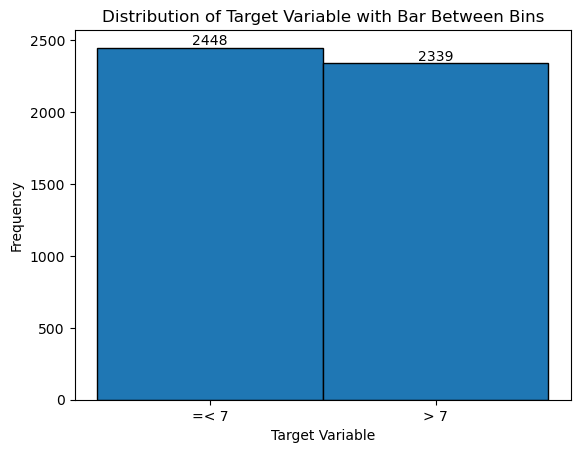

In [12]:
# printing a histogram of the target variable
plt.hist(baseline_dataset['target'], bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable with Bar Between Bins')
plt.xticks([0, 1], ['=< 7', '> 7'])
plt.dpi = 300
for i in range(len(baseline_dataset['target'].value_counts())):
    plt.text(i, baseline_dataset['target'].value_counts().iloc[i], str(baseline_dataset['target'].value_counts().iloc[i]), ha='center', va='bottom')
plt.show()

In [13]:
# the baseline dataset is now complete with the relevant features
# this dataset will be used in testing as the baseline dataset
# the dataset will be saved to a csv file
baseline_dataset.to_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/baseline_dataset.csv', sep=';', index=True)

In [14]:
# the health-related features will now be added into a new seperate dataset
#the basis is the baseline dataset, to which new features will be added
health_dataset = baseline_dataset.copy()

# self-rated health
# based on ch24q004
# add the value to the health dataset
health_dataset = health_dataset.join(
    dataframes_dict['health'][['ch24q004']].rename(columns={'ch24q004': 'self_rated_health'}),
    how='inner'
)

# mental health
# based on ch24q011, ch24q012
# sum the values of these variables
# join the rows where the index is in both dataframes
health_dataset = health_dataset.join(
    dataframes_dict['health'][['ch24q011', 'ch24q012']].sum(axis=1).rename('mental_health'),
    how='inner'
)

# chronic disease
# based on ch24q018
# 1 = yes, 2 = no, output is 1 = yes, 0 = no
# join the rows where the index is in both dataframes
health_dataset = health_dataset.join(
    dataframes_dict['health'][['ch24q018']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'ch24q018': 'chronic_disease'}),
    how='inner'
)

# behavior 
# based on ch24q125, ch24q133, ch24q159, ch24q160, ch24q161, ch24q162, ch24q163, ch24q270
# input: ch24q125; 1 = 1, 2 = 0, ch24q133; !=8 = 1, 8 = 0, if any of the other variables are 1, the value is 1, else 0
# a total of three is possible on a scale of 0-3, 1 from 125, 1 from 133, and 1 from the other variables
# join the rows where the index is in both dataframes

behavior_score = (
    dataframes_dict['health']['ch24q125'].apply(lambda x: 1 if x == 1 else 0) +
    dataframes_dict['health']['ch24q133'].apply(lambda x: 1 if x != 8 else 0) +
    dataframes_dict['health'][['ch24q159', 'ch24q160', 'ch24q161', 'ch24q162', 'ch24q163', 'ch24q270']].applymap(lambda x: 1 if x == 1 else 0).max(axis=1)
)
health_dataset = health_dataset.join(behavior_score.rename('behavior'), how='inner')

# physical activity
# based on ch24q023, ch24q024, ch24q025, ch24q026, ch24q027, ch24q028, ch24q029, ch24q030, ch24q031, ch24q032, ch24q033, ch24q034, ch24q044
# add up all the values, a high score indicates a high level of physical strain for regular activity
# join the rows where the index is in both dataframes
physical_activity_score = dataframes_dict['health'][['ch24q023', 'ch24q024', 'ch24q025', 'ch24q026', 'ch24q027', 'ch24q028', 'ch24q029', 'ch24q030', 'ch24q031', 'ch24q032', 'ch24q033', 'ch24q034', 'ch24q044']].sum(axis=1)
health_dataset = health_dataset.join(physical_activity_score.rename('physical_activity'), how='inner')

/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/382280027.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['health'][['ch24q018']].applymap(lambda x: 1 if x == 1 else 0).rename(columns={'ch24q018': 'chronic_disease'}),
/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_82042/382280027.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframes_dict['health'][['ch24q159', 'ch24q160', 'ch24q161', 'ch24q162', 'ch24q163', 'ch24q270']].applymap(lambda x: 1 if x == 1 else 0).max(axis=1)


In [15]:
# with the health set now too complete, the dataset will be saved to a csv file
health_dataset.to_csv('/Users/kevinduquesnoy/Documents/DSS/Thesis/Coding work/Datasets/LISS/health_dataset.csv', sep=';', index=True)


# 2. Model prediction

2.1 The baseline dataset

In [16]:
# train test split of baseline dataset
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    baseline_dataset.drop(columns=['target']),
    baseline_dataset['target'],
    test_size=0.2,
    random_state=14
)

# to test everything works quickly, the training dataset will be reduced
X_train = X_train.sample(frac=0.01, random_state=14)
y_train = y_train.sample(frac=0.01, random_state=14)


In [17]:
# standardize the data

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the training data
scaler.fit(X_train)
# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Return the scaled data to a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Preparing the CV loops

In [18]:
# defining models

# defining the models that will be used in the loops
# Dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=14)
# Random Forest classifier
rf_clf = RandomForestClassifier(random_state=14)
# SVM classifier
svm_clf = SVC(random_state=14)
# CatBoost classifier
catboost_clf = CatBoostClassifier(random_state=14, verbose=0)

# defining the hyperparameter grids for the models

# Random Forest classifier hyperparameter grid
rf_param_grid = {
    'n_estimators': [10, 50, 100, 250, 500, 1000],
    'max_depth': [2,4,8,16,24],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,5,10],
    'max_features': ['sqrt', 'log2', 'none'],
    'criterion': ['gini', 'entropy']
}
rf_param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# CatBoost classifier hyperparameter grid
catboost_param_grid = {
    'iterations': [100, 200, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10]
}

# SVM classifier hyperparameter grid
svm_param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
}

# defining the models and their hyperparameter grids in a dictionary
models = {
    'RandomForestClassifier': (rf_clf, rf_param_grid),
    'SVC': (svm_clf, svm_param_grid),
    'CatBoostClassifier': (catboost_clf, catboost_param_grid)
}


In [19]:
# creating the loops
Inner_folds = 5
Outer_folds = 5

# Initialize the KFold object for outer cross-validation
outer_cv = KFold(n_splits=Outer_folds, shuffle=True, random_state=14)
Inner_cv = KFold(n_splits=Inner_folds, shuffle=True, random_state=14)

# Initialize a dictionary to store the results
results = {}




In [20]:
# predicting with the dummy classifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
dummy_clf.fit(X_train_scaled, y_train)
dummy_pred = dummy_clf.predict(X_test_scaled)
dummy_accuracy = dummy_clf.score(X_test_scaled, y_test)



## Going through the inner loops for each of the models

In [21]:
# RF classifier
search_RF = HalvingGridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 1, aggressive_elimination=True, factor = 4, n_jobs=-1)
nested_RF_scores = cross_val_score(search_RF, X_train_scaled, y_train, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for Random Forest: {nested_RF_scores.mean():.4f} ± {nested_RF_scores.std():.4f}")
search_RF.fit(X_train_scaled, y_train)
print(search_RF.best_params_)
RF_results = {
    'Model': 'RandomForestClassifier',
    'Accuracy': search_RF.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, search_RF.predict(X_test_scaled)),
    'Precision': precision_score(y_test, search_RF.predict(X_test_scaled)),
    'Recall': recall_score(y_test, search_RF.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, search_RF.predict(X_test_scaled))
}


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 4
n_resources

In [156]:
# CatBoost classifier
search_CatBoost = HalvingGridSearchCV(estimator=catboost_clf, param_grid=catboost_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 2, aggressive_elimination=True, factor = 4, n_jobs=-1)
nested_CatBoost_scores = cross_val_score(search_CatBoost, X_train_scaled, y_train, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for CatBoost: {nested_CatBoost_scores.mean():.4f} ± {nested_CatBoost_scores.std():.4f}")
search_CatBoost.fit(X_train_scaled, y_train, verbose=1)
print(search_CatBoost.best_params_)
CatBoost_results = {
    'Model': 'CatBoostClassifier',
    'Accuracy': search_CatBoost.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, search_CatBoost.predict(X_test_scaled)),
    'Precision': precision_score(y_test, search_CatBoost.predict(X_test_scaled)),
    'Recall': recall_score(y_test, search_CatBoost.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, search_CatBoost.predict(X_test_scaled))
}

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 48
n_resources: 20
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.6s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.8s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.2s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.7s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..ite

In [157]:
# SVM classifier
search_SVM = HalvingGridSearchCV(estimator=svm_clf, param_grid=svm_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 2, aggressive_elimination=False, factor = 3, n_jobs=-1)
nested_SVM_scores = cross_val_score(search_SVM, X_train_scaled, y_train, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for SVM: {nested_SVM_scores.mean():.4f} ± {nested_SVM_scores.std():.4f}")
search_SVM.fit(X_train_scaled, y_train)
print(search_SVM.best_params_)
SVM_results = {
    'Model': 'SVC',
    'Accuracy': search_SVM.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, search_SVM.predict(X_test_scaled)),
    'Precision': precision_score(y_test, search_SVM.predict(X_test_scaled)),
    'Recall': recall_score(y_test, search_SVM.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, search_SVM.predict(X_test_scaled))
}


n_iterations: 1
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 20
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....

[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

In [158]:
# Training the best performing versions of all models on unseen data and final prediction
# Dummy classifier
dummy_clf.fit(X_train_scaled, y_train)
dummy_pred = dummy_clf.predict(X_test_scaled)

# # Random Forest classifier
rf_clf.set_params(**search_RF.best_params_)
rf_clf.fit(X_train_scaled, y_train)
rf_pred = rf_clf.predict(X_test_scaled)

# CatBoost classifier
catboost_clf.set_params(**search_CatBoost.best_params_)
catboost_clf.fit(X_train_scaled, y_train)
catboost_pred = catboost_clf.predict(X_test_scaled)

# SVM classifier
svm_clf.set_params(**search_SVM.best_params_)
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)

In [159]:
#AdversarialFairnessClassifier in nested CV


# --- 0. Data Preparation (Crucial) ---
X_train_full, X_holdout_test, y_train_full, y_holdout_test = train_test_split(
    baseline_dataset.drop(columns=['target']),
    baseline_dataset['target'],
    test_size=0.2,
    random_state=14
)
sensitive_feature_names_list = ['income'] 
sensitive_features_train_full = X_train_full[sensitive_feature_names_list]
sensitive_features_holdout_test = X_holdout_test[sensitive_feature_names_list]

main_feature_names = [col for col in X_train_full.columns if col not in sensitive_feature_names_list]
X_main_train_full = X_train_full[main_feature_names]
X_main_holdout_test = X_holdout_test[main_feature_names]

X_CV_SUBSAMPLE_FRAC = 0.01 # Using full available training data for CV
if X_CV_SUBSAMPLE_FRAC < 1.0:
    X_cv_main_features = X_main_train_full.sample(frac=X_CV_SUBSAMPLE_FRAC, random_state=14)
    y_cv = y_train_full.loc[X_cv_main_features.index]
    sf_cv = sensitive_features_train_full.loc[X_cv_main_features.index]
else:
    X_cv_main_features = X_main_train_full.copy()
    y_cv = y_train_full.copy()
    sf_cv = sensitive_features_train_full.copy()

print(f"Subsample fraction for CV data (X_CV_SUBSAMPLE_FRAC): {X_CV_SUBSAMPLE_FRAC}")
print(f"Shape of X_cv_main_features (data for nested CV): {X_cv_main_features.shape}")
print(f"Shape of y_cv (labels for nested CV): {y_cv.shape}")
print(f"Shape of sf_cv (sensitive features for nested CV): {sf_cv.shape}")
print(f"Shape of X_main_holdout_test (final holdout main features): {X_main_holdout_test.shape}")


# --- 1. Define CV Iterators ---
M_INNER_FOLDS = 5
K_OUTER_FOLDS = 5
inner_cv = KFold(n_splits=M_INNER_FOLDS, shuffle=True, random_state=14)
outer_cv = KFold(n_splits=K_OUTER_FOLDS, shuffle=True, random_state=14)

# --- 2. Define Parameter Grid for AdversarialFairnessClassifier ---
# Using the debug grid for potentially faster runs; expand as needed
param_grid_AFC = {
    'predictor_model': [[25], [50]],
    'adversary_model': [[3]],
    'learning_rate': [0.001, 0.01, 0.1],
    'alpha': [0,1, 0.5, 1]
}
current_param_grid = param_grid_AFC # Renamed for clarity

# --- 3. Manual Outer Loop for Nested Cross-Validation ---
fair_outer_loop_f1_scores = []
fair_all_best_params_outer = []

print(f"\nStarting Nested Cross-Validation for AdversarialFairnessClassifier with TensorFlow backend (Single Sensitive Feature)")
for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X_cv_main_features, y_cv)):
    print(f"--- Outer Fold {i + 1}/{K_OUTER_FOLDS} ---")

    X_train_outer_fold_main = X_cv_main_features.iloc[train_outer_idx]
    y_train_outer_fold = y_cv.iloc[train_outer_idx]
    sf_train_outer_fold = sf_cv.iloc[train_outer_idx]

    X_test_outer_fold_main = X_cv_main_features.iloc[test_outer_idx]
    y_test_outer_fold = y_cv.iloc[test_outer_idx]

    current_scaler = MinMaxScaler()
    X_train_outer_scaled_np = current_scaler.fit_transform(X_train_outer_fold_main).astype(np.float32)
    X_test_outer_scaled_np = current_scaler.transform(X_test_outer_fold_main).astype(np.float32)

    X_train_outer_scaled_np = np.clip(X_train_outer_scaled_np, 0, 1)
    X_test_outer_scaled_np = np.clip(X_test_outer_scaled_np, 0, 1)

    sf_train_outer_np = sf_train_outer_fold.astype(np.float32).to_numpy()
    if sf_train_outer_np.ndim == 1:
        sf_train_outer_np = sf_train_outer_np.reshape(-1, 1)

    base_afc_estimator = AdversarialFairnessClassifier(
        backend='tensorflow',
        random_state=14
    )
    search_AFC_inner = HalvingGridSearchCV(
        estimator=base_afc_estimator,
        param_grid=current_param_grid,
        scoring='f1_weighted',
        cv=inner_cv,
        refit=True,
        verbose=2, # Reduced verbosity for HalvingGridSearchCV in the loop
        aggressive_elimination=True,
        factor=4,
        n_jobs=-1,
        error_score='raise'
    )

    # print(f"  Starting Inner Loop (HalvingGridSearchCV) for Outer Fold {i + 1}...") # HalvingGridSearchCV verbose will indicate this
    try:
        search_AFC_inner.fit(
            X_train_outer_scaled_np,
            y_train_outer_fold,
            sensitive_features=sf_train_outer_np
        )
        # print(f"  Inner Loop Best Params for Outer Fold {i + 1}: {search_AFC_inner.best_params_}") # Can be enabled if needed
        fair_all_best_params_outer.append(search_AFC_inner.best_params_)

        y_pred_outer_test = search_AFC_inner.predict(X_test_outer_scaled_np)
        outer_fold_f1 = f1_score(y_test_outer_fold, y_pred_outer_test, average='weighted')
        fair_outer_loop_f1_scores.append(outer_fold_f1)
        print(f"  F1 Score on Outer Test Set for Fold {i + 1}: {outer_fold_f1:.4f}")
    except Exception as e_hcv:
        print(f"  HalvingGridSearchCV FAILED for Outer Fold {i + 1}: {type(e_hcv).__name__} - {e_hcv}")
        fair_outer_loop_f1_scores.append(np.nan)
        fair_all_best_params_outer.append(None)


# --- 4. Results of Nested Cross-Validation ---
valid_f1_scores = [s for s in fair_outer_loop_f1_scores if not np.isnan(s)]
if valid_f1_scores:
    mean_nested_f1 = np.mean(valid_f1_scores)
    std_nested_f1 = np.std(valid_f1_scores)
    print(f"\nMean Nested CV F1 Score (over successful folds): {mean_nested_f1:.4f} ± {std_nested_f1:.4f}")
else:
    print("\nAll outer folds failed during HalvingGridSearchCV.")

print("\n--- Nested Cross-Validation Summary for AFC ---")
print(f"Individual Outer Fold F1 Scores: {fair_outer_loop_f1_scores}")
print(f"Best params found in each outer fold's inner search (first 3 shown for successful folds):")
for p in fair_all_best_params_outer[:3]:
    if p: print(f"  {p}")


# --- 5. Final Model Training ---
print("\n--- Training Final AdversarialFairnessClassifier Model on Full Training Data (X_cv_main_features) ---")
if not valid_f1_scores:
    print("Skipping final model training as nested CV had issues.")
else:
    final_scaler = MinMaxScaler()
    X_cv_main_scaled_np = final_scaler.fit_transform(X_cv_main_features).astype(np.float32)
    X_cv_main_scaled_np = np.clip(X_cv_main_scaled_np, 0, 1)

    sf_cv_np = sf_cv.astype(np.float32).to_numpy()
    if sf_cv_np.ndim == 1:
        sf_cv_np = sf_cv_np.reshape(-1, 1)

    final_base_afc_estimator = AdversarialFairnessClassifier(
        backend='tensorflow',
        random_state=14
    )
    final_search_AFC = HalvingGridSearchCV(
        estimator=final_base_afc_estimator,
        param_grid=current_param_grid,
        scoring='f1_weighted',
        cv=inner_cv,
        refit=True,
        verbose=2, # Can set to 0 or 1 for final fit
        aggressive_elimination=True,
        factor=4,
        n_jobs=-1,
        error_score='raise'
    )
    try:
        final_search_AFC.fit(
            X_cv_main_scaled_np,
            y_cv,
            sensitive_features=sf_cv_np
        )
        print("\n--- Final Model Details (trained on X_cv_main_features) ---")
        print(f"Best Parameters found on X_cv_main_features: {final_search_AFC.best_params_}")
        final_AFC_model = final_search_AFC.best_estimator_
        print(f"Final Trained AdversarialFairnessClassifier Model: {final_AFC_model}")

        # --- 6. Evaluate Final Model on the True Hold-Out Test Set ---
        print("\n--- Evaluating Final Model on True Hold-Out Test Set (X_main_holdout_test) ---")
        X_main_holdout_test_scaled_np = final_scaler.transform(X_main_holdout_test).astype(np.float32)
        X_main_holdout_test_scaled_np = np.clip(X_main_holdout_test_scaled_np, 0, 1)

        y_pred_holdout = final_AFC_model.predict(X_main_holdout_test_scaled_np)
        
        holdout_f1 = f1_score(y_holdout_test, y_pred_holdout, average='weighted')
        holdout_accuracy = accuracy_score(y_holdout_test, y_pred_holdout)
        holdout_precision = precision_score(y_holdout_test, y_pred_holdout, average='weighted', zero_division=0)
        holdout_recall = recall_score(y_holdout_test, y_pred_holdout, average='weighted', zero_division=0)
        
        print(f"  Hold-Out F1 Score: {holdout_f1:.4f}")
        print(f"  Hold-Out Accuracy: {holdout_accuracy:.4f}")
        print(f"  Hold-Out Precision: {holdout_precision:.4f}")
        print(f"  Hold-Out Recall: {holdout_recall:.4f}")

        if hasattr(final_AFC_model, 'predict_proba'):
            try:
                y_proba_holdout = final_AFC_model.predict_proba(X_main_holdout_test_scaled_np)[:, 1]
                holdout_roc_auc = roc_auc_score(y_holdout_test, y_proba_holdout)
                print(f"  Hold-Out ROC AUC Score: {holdout_roc_auc:.4f}")
            except Exception as e_roc:
                print(f"  Could not calculate ROC AUC Score: {e_roc}")
        else:
            print("  ROC AUC Score: Not available (model does not have predict_proba method).")

    except Exception as e_final_fit:
        print(f"Final model training or evaluation FAILED: {type(e_final_fit).__name__} - {e_final_fit}")



Subsample fraction for CV data (X_CV_SUBSAMPLE_FRAC): 0.01
Shape of X_cv_main_features (data for nested CV): (38, 13)
Shape of y_cv (labels for nested CV): (38,)
Shape of sf_cv (sensitive features for nested CV): (38, 1)
Shape of X_main_holdout_test (final holdout main features): (958, 13)

Starting Nested Cross-Validation for AdversarialFairnessClassifier with TensorFlow backend (Single Sensitive Feature)
--- Outer Fold 1/5 ---
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 20
max_resources_: 30
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 24
n_resources: 20
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025-05-19 00:20:29.567538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 00:20:29.567538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 00:20:29.567749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 00:20:29.567539: I tensorflow/core/platform/cpu_featu

[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[25]; total time=  20.3s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[25]; total time=  20.3s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[25]; total time=  20.3s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[25]; total time=  20.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/py

[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[50]; total time=  22.0s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[25]; total time=  22.0s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[50]; total time=  20.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[50]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.001, predictor_model=[50]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.01, predictor_model=[25]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.01, predictor_model=[25]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.01, predictor_model=[25]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.01, predictor_model=[25]; total time=   0.5s
[CV] END adversary_model=[3], alpha=0, learning_rate=0.01, predictor_model=[25]; total time=   

In [160]:

# Evaluation 

# Determine sensitive features for evaluation
# sensitive_features_list = ['religious', 'income', 'education', 'employment_status']  
sensitive_features_list = ['income']
# Dummy classifier
dummy_eval = {
    'Model': 'DummyClassifier',
    'Accuracy': dummy_clf.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, dummy_clf.predict(X_test_scaled)),
    'Precision': precision_score(y_test, dummy_clf.predict(X_test_scaled)),
    'Recall': recall_score(y_test, dummy_clf.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, dummy_clf.predict(X_test_scaled))
}


# Random Forest classifier
RF_eval = {
    'Model': 'RandomForestClassifier',
    'Accuracy': rf_clf.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, rf_clf.predict(X_test_scaled)),
    'Precision': precision_score(y_test, rf_clf.predict(X_test_scaled)),
    'Recall': recall_score(y_test, rf_clf.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, rf_clf.predict(X_test_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test, rf_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list]),
    'Equalized Odds': equalized_odds_difference(y_test, rf_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list])
}


# CatBoost classifier
CatBoost_eval = {
    'Model': 'CatBoostClassifier',
    'Accuracy': catboost_clf.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, catboost_clf.predict(X_test_scaled)),
    'Precision': precision_score(y_test, catboost_clf.predict(X_test_scaled)),
    'Recall': recall_score(y_test, catboost_clf.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, catboost_clf.predict(X_test_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test, catboost_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list]),
    'Equalized Odds': equalized_odds_difference(y_test, catboost_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list])
}

# SVM classifier
SVM_eval = {
    'Model': 'SVC',
    'Accuracy': svm_clf.score(X_test_scaled, y_test),
    'F1 Score': f1_score(y_test, svm_clf.predict(X_test_scaled)),
    'Precision': precision_score(y_test, svm_clf.predict(X_test_scaled)),
    'Recall': recall_score(y_test, svm_clf.predict(X_test_scaled)),
    'ROC AUC Score': roc_auc_score(y_test, svm_clf.predict(X_test_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test, svm_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list]),
    'Equalized Odds': equalized_odds_difference(y_test, svm_clf.predict(X_test_scaled), sensitive_features=X_test_scaled[sensitive_features_list])
}

# Adversarial Fairness Classifier
AFC_eval = {
    'Model': 'AdversarialFairnessClassifier',
    'Accuracy': final_AFC_model.score(X_main_holdout_test_scaled_np, y_holdout_test),
    'F1 Score': f1_score(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np)),
    'Precision': precision_score(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np)),
    'Recall': recall_score(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np)),
    'ROC AUC Score': roc_auc_score(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np)),
    'Demographic Parity': demographic_parity_difference(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np), sensitive_features=X_test_scaled[sensitive_features_list]),
    'Equalized Odds': equalized_odds_difference(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np), sensitive_features=X_test_scaled[sensitive_features_list])
}

# Storing the results in a dictionary
results['DummyClassifier'] = dummy_eval
results['RandomForestClassifier'] = RF_eval
results['CatBoostClassifier'] = CatBoost_eval
results['SVC'] = SVM_eval
results['AdversarialFairnessClassifier'] = AFC_eval
# Saving the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', index=True)

print(results_df)


                    DummyClassifier  RandomForestClassifier  \
Model               DummyClassifier  RandomForestClassifier   
Accuracy                   0.478079                0.574113   
F1 Score                   0.646893                0.587879   
Precision                  0.478079                0.546992   
Recall                          1.0                0.635371   
ROC AUC Score                   0.5                0.576686   
Demographic Parity              NaN                     1.0   
Equalized Odds                  NaN                     1.0   

                    CatBoostClassifier       SVC  \
Model               CatBoostClassifier       SVC   
Accuracy                      0.563674  0.552192   
F1 Score                      0.568182  0.529089   
Precision                     0.539216  0.532009   
Recall                        0.600437  0.526201   
ROC AUC Score                 0.565218    0.5511   
Demographic Parity            0.965517       1.0   
Equalized Odds  

In [40]:
# Feature importance

# Permutation importance of features per model


def plot_permutation_importance(model, X_eval, y_eval, feature_names, model_name, n_repeats=10, random_state=14, n_jobs=1):
    """
    Calculates and plots permutation importance of features.

    Parameters:
    - model: The trained model.
    - X_eval: The evaluation data (features). Can be a NumPy array or pandas DataFrame.
    - y_eval: The true labels for the evaluation data.
    - feature_names: A list of strings representing the feature names, in the same order as columns in X_eval.
    - model_name: String, name of the model for the plot title.
    - n_repeats: Number of times to permute a feature.
    - random_state: Random state for reproducibility.
    """
    print(f"\nCalculating permutation importance for {model_name}...")
    
    # Ensure X_eval is a NumPy array for permutation_importance if model was fit on NumPy
    # This is generally good practice to avoid potential issues with DataFrame indexing within the function
    if isinstance(X_eval, pd.DataFrame):
        X_eval_np = X_eval.to_numpy()
    else:
        X_eval_np = X_eval

    result = permutation_importance(
        model, X_eval_np, y_eval, 
        n_repeats=n_repeats, 
        random_state=random_state,
        n_jobs=1 # Use multiple cores if available
    )
    
    sorted_idx = result.importances_mean.argsort() # Sorts from smallest to largest

    if len(feature_names) != len(result.importances_mean):
        print(f"  WARNING for {model_name}: Number of feature names ({len(feature_names)}) "
              f"does not match number of importances ({len(result.importances_mean)}). "
              "Plotting might be incorrect.")
        # Fallback if lengths don't match - this shouldn't happen if feature_names is correct
        effective_feature_names = [f"Feature {i}" for i in range(len(result.importances_mean))]
    else:
        effective_feature_names = np.array(feature_names)[sorted_idx]

    plt.figure(figsize=(10, max(6, len(effective_feature_names) * 0.4))) # Adjust height based on num features
    plt.barh(effective_feature_names, result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance Mean", fontweight='bold')
    plt.ylabel("Feature", fontweight='bold')
    plt.title(f"Permutation Importance - {model_name}", fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot permutation importance for each model
plot_permutation_importance(rf_clf, X_test_scaled, y_test, X_test_scaled.columns, 'RandomForestClassifier')
plot_permutation_importance(catboost_clf, X_test_scaled, y_test, X_test_scaled.columns, 'CatBoostClassifier')
plot_permutation_importance(svm_clf, X_test_scaled, y_test, X_test_scaled.columns, 'SVC')
plot_permutation_importance(final_AFC_model, X_main_holdout_test_scaled_np, y_holdout_test, X_main_holdout_test.columns, 'AdversarialFairnessClassifier')


NameError: name 'rf_clf' is not defined

In [60]:
# check feature correlation


# correlation matrix
correlation_matrix = baseline_dataset.corr()
#creating a filtered correlation matrix for values in the upper and lower 20% of correlation values
threshold = 0.2
mask = (correlation_matrix > threshold) | (correlation_matrix < -threshold)
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix[mask], annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



/var/folders/hk/gkxw9p6d3wb6_vcyr1zh90780000gn/T/ipykernel_80955/2954648506.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_correlation_matrix = correlation_matrix.applymap(


NameError: name 'mask' is not defined

<Figure size 1200x1000 with 0 Axes>

In [63]:
# Generating confusion matrices for all model predictions


def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix for the given true and predicted labels.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model for the plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos'])
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, dummy_clf.predict(X_test_scaled), 'DummyClassifier')
plot_confusion_matrix(y_test, rf_clf.predict(X_test_scaled), 'RandomForestClassifier')
plot_confusion_matrix(y_test, catboost_clf.predict(X_test_scaled), 'CatBoostClassifier')
plot_confusion_matrix(y_test, svm_clf.predict(X_test_scaled), 'SVC')
plot_confusion_matrix(y_holdout_test, final_AFC_model.predict(X_main_holdout_test_scaled_np), 'AdversarialFairnessClassifier')

NameError: name 'dummy_clf' is not defined

2.2 The health dataset (the same actions with the models that are already created (no hyperparam tuning, the best models will be employed)

In [18]:
# train test split health data
# Split the dataset into training and testing sets
X_train_health, X_test_health, y_train_health, y_test_health = train_test_split(
    health_dataset.drop(columns=['target']),
    health_dataset['target'],
    test_size=0.2,
    random_state=14
)

# to test everything works quickly, the training dataset will be reduced
X_train_health = X_train_health.sample(frac=0.1, random_state=14)
y_train_health = y_train_health.sample(frac=0.1, random_state=14)

In [19]:
#standardize the data
scaler = StandardScaler()
# Fit the scaler to the training data
scaler.fit(X_train_health)
# Transform the training and testing data
X_train_health_scaled = scaler.transform(X_train_health)
X_test_health_scaled = scaler.transform(X_test_health)
# Return the scaled data to a dataframe
X_train_health_scaled = pd.DataFrame(X_train_health_scaled, columns=X_train_health.columns)
X_test_health_scaled = pd.DataFrame(X_test_health_scaled, columns=X_test_health.columns)


Preparing the CV loops

In [24]:
#defining models

# defining the models that will be used in the loops
# Dummy classifier
dummy_clf_health = DummyClassifier(strategy='most_frequent', random_state=14)

# Random Forest classifier
rf_clf_health = RandomForestClassifier(random_state=14)

# SVM classifier
svm_clf_health = SVC(random_state=14)

# CatBoost classifier
catboost_clf_health = CatBoostClassifier(random_state=14, verbose=0)

# Random Forest classifier hyperparameter grid
rf_param_grid = {
    'n_estimators': [10, 50, 100, 250, 500, 1000],
    'max_depth': [2,4,8,16,24],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,5,10],
    'max_features': ['sqrt', 'log2', 'none'],
    'criterion': ['gini', 'entropy']
}
rf_param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# CatBoost classifier hyperparameter grid
catboost_param_grid = {
    'iterations': [100, 200, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10]
}

# SVM classifier hyperparameter grid
svm_param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
}

# defining the models and their hyperparameter grids in a dictionary
models_health = {
    'RandomForestClassifier': (rf_clf_health, rf_param_grid),
    'SVC': (svm_clf_health, svm_param_grid),
    'CatBoostClassifier': (catboost_clf_health, catboost_param_grid)
}

In [21]:
# creating the loops
Inner_folds = 5
Outer_folds = 5

# Initialize the KFold object for outer cross-validation
outer_cv = KFold(n_splits=Outer_folds, shuffle=True, random_state=14)
Inner_cv = KFold(n_splits=Inner_folds, shuffle=True, random_state=14)

# Initialize a dictionary to store the results
results_health = {}

In [22]:
# predicting with the dummy classifier
dummy_clf_health.fit(X_train_health_scaled, y_train_health)
dummy_pred_health = dummy_clf_health.predict(X_test_health_scaled)
dummy_accuracy_health = dummy_clf_health.score(X_test_health_scaled, y_test_health)

# Going through the inner loops for each of the models on the health data

In [27]:
# RF classifier

search_RF_health = HalvingGridSearchCV(estimator=rf_clf_health, param_grid=rf_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 1, aggressive_elimination=True, factor = 4, n_jobs=-1)
nested_RF_scores_health = cross_val_score(search_RF_health, X_train_health_scaled, y_train_health, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for Random Forest: {nested_RF_scores_health.mean():.4f} ± {nested_RF_scores_health.std():.4f}")
search_RF_health.fit(X_train_health_scaled, y_train_health)
print(search_RF_health.best_params_)
RF_results_health = {
    'Model': 'RandomForestClassifier',
    'Accuracy': search_RF_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, search_RF_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, search_RF_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, search_RF_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, search_RF_health.predict(X_test_health_scaled))
}

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 295
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 295
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 295
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 295
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 296
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 20
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Nested CV F1 Score for Random Forest: 0.5336 ± 0.0689
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23
max_resources_: 369
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 16
n_resources: 23
Fitting 5 folds for each of 16 candidates, totallin

In [28]:
# CatBoost classifier
search_CatBoost_health = HalvingGridSearchCV(estimator=catboost_clf_health, param_grid=catboost_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 2, aggressive_elimination=True, factor = 4, n_jobs=-1)
nested_CatBoost_scores_health = cross_val_score(search_CatBoost_health, X_train_health_scaled, y_train_health, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for CatBoost: {nested_CatBoost_scores_health.mean():.4f} ± {nested_CatBoost_scores_health.std():.4f}")
search_CatBoost_health.fit(X_train_health_scaled, y_train_health, verbose=1)
print(search_CatBoost_health.best_params_)
CatBoost_results_health = {
    'Model': 'CatBoostClassifier',
    'Accuracy': search_CatBoost_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, search_CatBoost_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, search_CatBoost_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, search_CatBoost_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, search_CatBoost_health.predict(X_test_health_scaled))
}

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 295
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 48
n_resources: 20
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=100, 

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.01; total time=   0.2s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.2s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.01; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ...iterations=100, 

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.2s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.2s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.6s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ...iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.4s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s

[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.7s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.01; total time=   0.9s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.8s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.9s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.6s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.6s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.6s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ...iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ...iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ...iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.01; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.01; total time=   0.5s
[CV] END ...iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.01; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=5, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=300, l2_leaf_reg=5, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=5, learning_rate=0.1; total time=   0.4s
[CV] END ...iterations=300, l2_leaf_reg=5, learning_rate=0.1; total time=   0.4s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.4s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.4s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.5s
[CV] END ...iterations=300, l2_leaf_reg=5, learning_rate=0.1; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.05; total time=   0.6s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.05; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.05; total time=   0.6s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.05; total time=   1.0s
[CV] END ..iterations=300, l2_leaf_reg=10, learning_rate=0.1; total time=   1.1s
[CV] END ..iterations=300, l2_leaf_reg=10, learning_rate=0.1; total time=   1.0s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.05; total time=   1.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=10, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=10, learning_rate=0.1; total time=   0.6s
[CV] END ..iterations=300, l2_leaf_reg=10, learning_rate=0.1; total time=   0.6s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.5s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=   1.5s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.3s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.4s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=   1.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=   1.4s
[CV] END ..iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   1.8s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=   1.9s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   1.8s
[CV] END ..iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   2.1s
[CV] END ..iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   1.6s
[CV] END .iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=   1.7s
[CV] END ..iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   1.8s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   1.7s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   1.6s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   1.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   1.6s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   1.5s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   1.4s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   1.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   1.4s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   1.3s
[CV] END .iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   1.5s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.5s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.6s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.7s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.5s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.01; total time=   1.6s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.01; total time=   1.6s[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.01; total time=   1.5s

[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.01; total time=   2.0s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.01; total time=   2.2s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=   1.9s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=   2.0s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=   1.5s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=   1.7s
[CV] END .iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=   1.5s
[CV] END ..iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=   1.5s
[CV] END ..iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=   1.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=   1.5s
[CV] END ..iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=   1.7s
[CV] END ..iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=   1.6s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.01; total time=   1.5s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.01; total time=   1.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.01; total time=   2.3s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.01; total time=   2.5s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.01; total time=   2.8s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.05; total time=   4.1s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.05; total time=   3.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.05; total time=   3.3s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.05; total time=   3.1s
[CV] END iterations=1000, l2_leaf_reg=10, learning_rate=0.05; total time=   1.8s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   1.4s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.2s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   3.0s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   3.2s
----------
iter: 1
n_candidates: 12
n_resources: 20
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.5s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   1.0s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.8s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.8s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.7s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.01; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.5s
[CV] END ...iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   0.5s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   0.3s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.5s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.6s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.6s
[CV] END ...iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   0.6s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.4s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=200, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.5s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.5s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.9s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   3.3s
[CV] END .iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   2.0s
----------
iter: 2
n_candidates: 3
n_resources: 80
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.7s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=200, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.3s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.05; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.2s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.2s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END ...iterations=100, l2_leaf_reg=5, learning_rate=0.1; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.2s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.2s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.2s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.3s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.05; total time=   0.3s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.2s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.4s
[CV] END ..iterations=100, l2_leaf_reg=10, learning_rate=0.1; total time=   0.1s
[CV] END ..iterations=200, l

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.2s
[CV] END ..iterations=100, l2_leaf_reg=5, learning_rate=0.01; total time=   0.2s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.7s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.5s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.7s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.2s
[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.1s
[CV] END .iterations=100, l2

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .iterations=100, l2_leaf_reg=10, learning_rate=0.01; total time=   0.3s
[CV] END .iterations=300, l2_leaf_reg=10, learning_rate=0.01; total time=   0.6s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.4s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.5s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   3.3s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   3.9s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   1.0s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.7s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=300, l2_leaf_reg=3, learning_rate=0.05; total time=   0.5s
[CV] END ..iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.0s
[CV] END ...iterations=300, 

In [29]:
# SVM classifier
search_SVM_health = HalvingGridSearchCV(estimator=svm_clf_health, param_grid=svm_param_grid, scoring='f1', cv=Inner_cv, random_state=14, refit = True, verbose = 2, aggressive_elimination=False, factor = 3, n_jobs=-1)
nested_SVM_scores_health = cross_val_score(search_SVM_health, X_train_health_scaled, y_train_health, cv=outer_cv, scoring='f1')
print(f"Nested CV F1 Score for SVM: {nested_SVM_scores_health.mean():.4f} ± {nested_SVM_scores_health.std():.4f}")
search_SVM_health.fit(X_train_health_scaled, y_train_health)
print(search_SVM_health.best_params_)
SVM_results_health = {
    'Model': 'SVC',
    'Accuracy': search_SVM_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, search_SVM_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, search_SVM_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, search_SVM_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, search_SVM_health.predict(X_test_health_scaled))
}

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 20
max_resources_: 295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 20
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.2s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.2s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.3s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.3s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.2s
[CV] END ...

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.1s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ................C=0

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.1s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
----------
iter: 1
n_candidates: 16
n_resources: 60
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................C

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.1s[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.1s

[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ................C=0

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s

[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.1s



/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.2s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=   0.1s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=   0.0s[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ...............C=0.001, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ................C=0

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s

[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tru

[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ...................

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.001, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

In [30]:
# Training the best performing versions of all models on unseen data and final prediction
# Dummy classifier
dummy_clf_health.fit(X_train_health_scaled, y_train_health)
dummy_pred_health = dummy_clf_health.predict(X_test_health_scaled)

# # Random Forest classifier
rf_clf_health.set_params(**search_RF_health.best_params_)
rf_clf_health.fit(X_train_health_scaled, y_train_health)
rf_pred_health = rf_clf_health.predict(X_test_health_scaled)

# CatBoost classifier
catboost_clf_health.set_params(**search_CatBoost_health.best_params_)
catboost_clf_health.fit(X_train_health_scaled, y_train_health)
catboost_pred_health = catboost_clf_health.predict(X_test_health_scaled)

# SVM classifier
svm_clf_health.set_params(**search_SVM_health.best_params_)
svm_clf_health.fit(X_train_health_scaled, y_train_health)
svm_pred_health = svm_clf_health.predict(X_test_health_scaled)


In [55]:


# --- 0. Data Preparation (Crucial) ---
X_train_health_full, X_holdout_test_health, y_train_health_full, y_holdout_test_health = train_test_split(
    health_dataset.drop(columns=['target']),
    health_dataset['target'],
    test_size=0.2,
    random_state=14
)

sf_for_training_train_full_health = X_train_health_full[sensitive_feature_names_list_health]

all_sensitive_feature_names_for_eval_health = ['income', 'education', 'employment_status', 'religious']
all_sf_holdout_test_health = X_holdout_test_health[all_sensitive_feature_names_for_eval_health]

main_feature_names_health = [col for col in X_train_health_full.columns if col not in all_sensitive_feature_names_for_eval_health]
X_main_train_health_full = X_train_health_full[main_feature_names_health]
X_main_holdout_test_health = X_holdout_test_health[main_feature_names_health]


X_CV_SUBSAMPLE_FRAC = 0.1
if X_CV_SUBSAMPLE_FRAC < 1.0:
    X_cv_main_features_health = X_main_train_health_full.sample(frac=X_CV_SUBSAMPLE_FRAC, random_state=14)
    y_cv_health = y_train_health_full.loc[X_cv_main_features_health.index]
    sf_cv_health_for_training = sf_for_training_train_full_health.loc[X_cv_main_features_health.index]
else:
    X_cv_main_features_health = X_main_train_health_full.copy()
    y_cv_health = y_train_health_full.copy()
    sf_cv_health_for_training = sf_for_training_train_full_health.copy()


print(f"Subsample fraction for CV data (X_CV_SUBSAMPLE_FRAC): {X_CV_SUBSAMPLE_FRAC}")
print(f"Shape of X_cv_main_features_health (data for nested CV): {X_cv_main_features_health.shape}")
print(f"Shape of y_cv_health (labels for nested CV): {y_cv_health.shape}")
print(f"Shape of sf_cv_health_for_training (sensitive features for AFC training in CV): {sf_cv_health_for_training.shape}")
print(f"Shape of X_main_holdout_test_health (final holdout main features): {X_main_holdout_test_health.shape}")
print(f"Shape of all_sf_holdout_test_health (all SF for final fairness eval): {all_sf_holdout_test_health.shape}")


# --- 1. Define CV Iterators ---
M_INNER_FOLDS = 5
K_OUTER_FOLDS = 5
inner_cv_health = KFold(n_splits=M_INNER_FOLDS, shuffle=True, random_state=14)
outer_cv_health = KFold(n_splits=K_OUTER_FOLDS, shuffle=True, random_state=14)

# --- 2. Define Parameter Grid for AdversarialFairnessClassifier ---
param_grid_AFC_health = {
    'predictor_model': [[25], [50]],
    'adversary_model': [[3]],
    'learning_rate': [0.001, 0.01, 0.1],
    'alpha': [0.1, 0.5, 1]
}
current_param_grid_health = param_grid_AFC_health

# --- 3. Manual Outer Loop for Nested Cross-Validation ---
fair_outer_loop_f1_scores_health = []
fair_all_best_params_outer_health = []

print(f"\nStarting Nested Cross-Validation for AdversarialFairnessClassifier with TensorFlow backend")
for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv_health.split(X_cv_main_features_health, y_cv_health)):
    print(f"--- Outer Fold {i + 1}/{K_OUTER_FOLDS} ---")

    X_train_outer_fold_main_health_df = X_cv_main_features_health.iloc[train_outer_idx]
    y_train_outer_fold_health = y_cv_health.iloc[train_outer_idx]
    sf_train_outer_fold_health = sf_cv_health_for_training.iloc[train_outer_idx]

    X_test_outer_fold_main_health_df = X_cv_main_features_health.iloc[test_outer_idx]
    y_test_outer_fold_health = y_cv_health.iloc[test_outer_idx]

    current_scaler = MinMaxScaler()
    # Fit scaler on DataFrame to capture feature names if scaler supports it
    X_train_outer_scaled_np_health = current_scaler.fit_transform(X_train_outer_fold_main_health_df).astype(np.float32)
    X_test_outer_scaled_np_health = current_scaler.transform(X_test_outer_fold_main_health_df).astype(np.float32)

    X_train_outer_scaled_np_health = np.clip(X_train_outer_scaled_np_health, 0, 1)
    X_test_outer_scaled_np_health = np.clip(X_test_outer_scaled_np_health, 0, 1)

    sf_train_outer_np_health = sf_train_outer_fold_health.astype(np.float32).to_numpy()
    if sf_train_outer_np_health.ndim == 1:
        sf_train_outer_np_health = sf_train_outer_np_health.reshape(-1, 1)

    base_afc_estimator = AdversarialFairnessClassifier(
        backend='tensorflow',
        random_state=14
    )
    search_AFC_inner_health = HalvingGridSearchCV(
        estimator=base_afc_estimator,
        param_grid=current_param_grid_health,
        scoring='f1_weighted',
        cv=inner_cv_health,
        refit=True,
        verbose=0,
        aggressive_elimination=True,
        factor=4,
        n_jobs=-1,
        error_score='raise'
    )
    try:
        # Pass NumPy array to HalvingGridSearchCV fit, as AFC should handle NumPy
        search_AFC_inner_health.fit(
            X_train_outer_scaled_np_health,
            y_train_outer_fold_health,
            sensitive_features=sf_train_outer_np_health
        )
        fair_all_best_params_outer_health.append(search_AFC_inner_health.best_params_)
        
        # For prediction, if model expects names, convert NumPy back to DataFrame with correct names
        X_test_outer_scaled_df_health = pd.DataFrame(X_test_outer_scaled_np_health, columns=main_feature_names_health)
        y_pred_outer_test_health = search_AFC_inner_health.predict(X_test_outer_scaled_df_health)
        
        outer_fold_f1_health = f1_score(y_test_outer_fold_health, y_pred_outer_test_health, average='weighted')
        fair_outer_loop_f1_scores_health.append(outer_fold_f1_health)
        print(f"  F1 Score on Outer Test Set for Fold {i + 1}: {outer_fold_f1_health:.4f}")
    except Exception as e_hcv:
        print(f"  HalvingGridSearchCV FAILED for Outer Fold {i + 1}: {type(e_hcv).__name__} - {e_hcv}")
        fair_outer_loop_f1_scores_health.append(np.nan)
        fair_all_best_params_outer_health.append(None)

# --- 4. Results of Nested Cross-Validation ---
valid_f1_scores_health = [s for s in fair_outer_loop_f1_scores_health if not np.isnan(s)]
if valid_f1_scores_health:
    mean_nested_f1_health = np.mean(valid_f1_scores_health)
    std_nested_f1_health = np.std(valid_f1_scores_health)
    print(f"\nMean Nested CV F1 Score (over successful folds): {mean_nested_f1_health:.4f} ± {std_nested_f1_health:.4f}")
else:
    print("\nAll outer folds failed during HalvingGridSearchCV.")
# ... (print best params if needed)

# --- 5. Final Model Training ---
print("\n--- Training Final AdversarialFairnessClassifier Model on Full CV Data (X_cv_main_features_health) ---")
final_AFC_model_health = None
if not valid_f1_scores_health:
    print("Skipping final model training as nested CV had issues.")
else:
    final_scaler_health = MinMaxScaler()
    # Fit scaler on DataFrame to capture feature names if scaler supports it
    X_cv_main_scaled_np_health = final_scaler_health.fit_transform(X_cv_main_features_health).astype(np.float32)
    X_cv_main_scaled_np_health = np.clip(X_cv_main_scaled_np_health, 0, 1)

    sf_cv_np_health_for_training = sf_cv_health_for_training.astype(np.float32).to_numpy()
    if sf_cv_np_health_for_training.ndim == 1:
        sf_cv_np_health_for_training = sf_cv_np_health_for_training.reshape(-1, 1)

    final_base_afc_estimator_health = AdversarialFairnessClassifier(
        backend='tensorflow',
        random_state=14
    )
    final_search_AFC_health = HalvingGridSearchCV(
        estimator=final_base_afc_estimator_health,
        param_grid=current_param_grid_health,
        scoring='f1_weighted',
        cv=inner_cv_health,
        refit=True,
        verbose=1,
        aggressive_elimination=True,
        factor=4,
        n_jobs=-1,
        error_score='raise'
    )
    try:
        # Pass NumPy array to HalvingGridSearchCV fit
        final_search_AFC_health.fit(
            X_cv_main_scaled_np_health,
            y_cv_health,
            sensitive_features=sf_cv_np_health_for_training
        )
        print("\n--- Final Model Details (trained on X_cv_main_features_health) ---")
        print(f"Best Parameters found on X_cv_main_features_health: {final_search_AFC_health.best_params_}")
        final_AFC_model_health = final_search_AFC_health.best_estimator_
        print(f"Final Trained AdversarialFairnessClassifier Model: {final_AFC_model_health}")

    except Exception as e_final_fit:
        print(f"Final model training FAILED: {type(e_final_fit).__name__} - {e_final_fit}")

# --- 6. Evaluate Final Model on the True Hold-Out Test Set ---
if final_AFC_model_health is not None:
    print("\n--- Evaluating Final Model on True Hold-Out Test Set (X_main_holdout_test_health) ---")
    
    X_main_holdout_test_scaled_np_health = final_scaler_health.transform(X_main_holdout_test_health).astype(np.float32)
    X_main_holdout_test_scaled_np_health = np.clip(X_main_holdout_test_scaled_np_health, 0, 1)

    # Convert holdout data to DataFrame with correct feature names for prediction
    X_main_holdout_test_scaled_df_health = pd.DataFrame(
        X_main_holdout_test_scaled_np_health,
        columns=main_feature_names_health # Use the same feature names model was trained on
    )
    
    y_pred_holdout_health = final_AFC_model_health.predict(X_main_holdout_test_scaled_df_health)
    
    all_sf_holdout_test_np_health = all_sf_holdout_test_health.astype(np.float32).to_numpy()

    AFC_eval_health = {
        'Model': 'AdversarialFairnessClassifier',
        'Accuracy': accuracy_score(y_holdout_test_health, y_pred_holdout_health),
        'F1 Score': f1_score(y_holdout_test_health, y_pred_holdout_health, average='weighted'),
        'Precision': precision_score(y_holdout_test_health, y_pred_holdout_health, average='weighted', zero_division=0),
        'Recall': recall_score(y_holdout_test_health, y_pred_holdout_health, average='weighted', zero_division=0)
    }
    
    if hasattr(final_AFC_model_health, 'predict_proba'):
        try:
            # Pass DataFrame with feature names to predict_proba as well
            y_proba_holdout_health = final_AFC_model_health.predict_proba(X_main_holdout_test_scaled_df_health)[:, 1]
            AFC_eval_health['ROC AUC Score'] = roc_auc_score(y_holdout_test_health, y_proba_holdout_health)
        except Exception as e_roc:
            print(f"  Could not calculate ROC AUC Score: {e_roc}")
            AFC_eval_health['ROC AUC Score'] = np.nan
    else:
        print("  ROC AUC Score: Not available (model does not have predict_proba method).")
        AFC_eval_health['ROC AUC Score'] = np.nan

    for idx, sf_name in enumerate(all_sensitive_feature_names_for_eval_health):
        current_sf_column_holdout = all_sf_holdout_test_np_health[:, idx]
        try:
            dpd = demographic_parity_difference(
                y_true=y_holdout_test_health, y_pred=y_pred_holdout_health,
                sensitive_features=current_sf_column_holdout)
            AFC_eval_health[f'Demographic Parity Difference ({sf_name})'] = dpd
        except Exception as e_dpd:
            AFC_eval_health[f'Demographic Parity Difference ({sf_name})'] = np.nan
        try:
            eod = equalized_odds_difference(
                y_true=y_holdout_test_health, y_pred=y_pred_holdout_health,
                sensitive_features=current_sf_column_holdout)
            AFC_eval_health[f'Equalized Odds Difference ({sf_name})'] = eod
        except Exception as e_eod:
            AFC_eval_health[f'Equalized Odds Difference ({sf_name})'] = np.nan
            
    print("\n--- AFC Evaluation Metrics on Hold-Out Set ---")
    for metric_name, metric_value in AFC_eval_health.items():
        if isinstance(metric_value, float): print(f"  {metric_name}: {metric_value:.4f}")
        else: print(f"  {metric_name}: {metric_value}")
else:
    print("Final AFC model was not trained due to issues in nested CV or final training.")



Subsample fraction for CV data (X_CV_SUBSAMPLE_FRAC): 0.1
Shape of X_cv_main_features_health (data for nested CV): (369, 15)
Shape of y_cv_health (labels for nested CV): (369,)
Shape of sf_cv_health_for_training (sensitive features for AFC training in CV): (369, 1)
Shape of X_main_holdout_test_health (final holdout main features): (924, 15)
Shape of all_sf_holdout_test_health (all SF for final fairness eval): (924, 4)

Starting Nested Cross-Validation for AdversarialFairnessClassifier with TensorFlow backend
--- Outer Fold 1/5 ---


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-19 03:13:53.700828: I tensorflow/core/platform/cpu_feature_guard.cc:

  F1 Score on Outer Test Set for Fold 1: 0.4271
--- Outer Fold 2/5 ---


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


  F1 Score on Outer Test Set for Fold 2: 0.4295
--- Outer Fold 3/5 ---


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


  F1 Score on Outer Test Set for Fold 3: 0.3037
--- Outer Fold 4/5 ---


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


  F1 Score on Outer Test Set for Fold 4: 0.4599
--- Outer Fold 5/5 ---


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


  F1 Score on Outer Test Set for Fold 5: 0.4367

Mean Nested CV F1 Score (over successful folds): 0.4114 ± 0.0551

--- Training Final AdversarialFairnessClassifier Model on Full CV Data (X_cv_main_features_health) ---
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 23
max_resources_: 369
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 18
n_resources: 23
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 5
n_resources: 92
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 368
Fitting 5 folds for each of 2 candidates, totalling 10 fits

--- Final Model Details (trained on X_cv_main_features_health) ---
Best Parameters found on X_cv_main_features_health: {'adversary_model': [3], 'alpha': 0.1, 'learning_rate': 0.001, 'predictor_model': [50]}
Final Trained AdversarialFairnessClassifier Model: AdversarialFairnessClassifier(adversary_mod

/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(



--- AFC Evaluation Metrics on Hold-Out Set ---
  Model: AdversarialFairnessClassifier
  Accuracy: 0.5130
  F1 Score: 0.3672
  Precision: 0.5181
  Recall: 0.5130
  ROC AUC Score: nan
  Demographic Parity Difference (income): 0.0909
  Equalized Odds Difference (income): 0.2500
  Demographic Parity Difference (education): 0.2000
  Equalized Odds Difference (education): 0.5000
  Demographic Parity Difference (employment_status): 0.0612
  Equalized Odds Difference (employment_status): 0.0769
  Demographic Parity Difference (religious): 0.0099
  Equalized Odds Difference (religious): 0.0256


In [56]:
# Evaluation 

# Determine sensitive features for evaluation
# sensitive_features_list = ['religious', 'income', 'education', 'employment_status']
sensitive_features_list_health = ['income']
# Dummy classifier
dummy_eval_health = {
    'Model': 'DummyClassifier',
    'Accuracy': dummy_clf_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, dummy_clf_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, dummy_clf_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, dummy_clf_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, dummy_clf_health.predict(X_test_health_scaled))
}

# Random Forest classifier
RF_eval_health = {
    'Model': 'RandomForestClassifier',
    'Accuracy': rf_clf_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, rf_clf_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, rf_clf_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, rf_clf_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, rf_clf_health.predict(X_test_health_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test_health, rf_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health]),
    'Equalized Odds': equalized_odds_difference(y_test_health, rf_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health])
}

# CatBoost classifier
CatBoost_eval_health = {
    'Model': 'CatBoostClassifier',
    'Accuracy': catboost_clf_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, catboost_clf_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, catboost_clf_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, catboost_clf_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, catboost_clf_health.predict(X_test_health_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test_health, catboost_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health]),
    'Equalized Odds': equalized_odds_difference(y_test_health, catboost_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health])
}

# SVM classifier
SVM_eval_health = {
    'Model': 'SVC',
    'Accuracy': svm_clf_health.score(X_test_health_scaled, y_test_health),
    'F1 Score': f1_score(y_test_health, svm_clf_health.predict(X_test_health_scaled)),
    'Precision': precision_score(y_test_health, svm_clf_health.predict(X_test_health_scaled)),
    'Recall': recall_score(y_test_health, svm_clf_health.predict(X_test_health_scaled)),
    'ROC AUC Score': roc_auc_score(y_test_health, svm_clf_health.predict(X_test_health_scaled)),
    'Demographic Parity': demographic_parity_difference(y_test_health, svm_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health]),
    'Equalized Odds': equalized_odds_difference(y_test_health, svm_clf_health.predict(X_test_health_scaled), sensitive_features=X_test_health_scaled[sensitive_features_list_health])
}

# debugging different input sizes
print(f"y_holdout_test_health shape: {y_holdout_test_health.shape}")
print(f"Predictions shape: {final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health).shape}")
print(f"Sensitive features shape: {X_test_health_scaled[sensitive_features_list_health].shape}")


# Adversarial Fairness Classifier
AFC_eval_health = {
    'Model': 'AdversarialFairnessClassifier',
    'Accuracy': final_AFC_model_health.score(X_main_holdout_test_scaled_np_health, y_holdout_test_health),
    'F1 Score': f1_score(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health)),
    'Precision': precision_score(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health)),
    'Recall': recall_score(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health)),
    'ROC AUC Score': roc_auc_score(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health)),
    'Demographic Parity': demographic_parity_difference(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health), sensitive_features=X_test_health_scaled[sensitive_features_list_health]),
    'Equalized Odds': equalized_odds_difference(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health), sensitive_features=X_test_health_scaled[sensitive_features_list_health])
}

# Storing the results in a dictionary
results_health['DummyClassifier'] = dummy_eval_health
results_health['RandomForestClassifier'] = RF_eval_health
results_health['CatBoostClassifier'] = CatBoost_eval_health
results_health['SVC'] = SVM_eval_health
results_health['AdversarialFairnessClassifier'] = AFC_eval_health
# Saving the results to a CSV file
results_df_health = pd.DataFrame(results_health)
results_df_health.to_csv('model_results_health.csv', index=True)

print(results_df_health)



/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_holdout_test_health shape: (924,)
Predictions shape: (924,)
Sensitive features shape: (924, 1)
                    DummyClassifier  RandomForestClassifier  \
Model               DummyClassifier  RandomForestClassifier   
Accuracy                   0.511905                0.627706   
F1 Score                        0.0                0.575309   
Precision                       0.0                0.649025   
Recall                          0.0                 0.51663   
ROC AUC Score                   0.5                0.625122   
Demographic Parity              NaN                0.525424   
Equalized Odds                  NaN                0.666667   

                    CatBoostClassifier       SVC  \
Model               CatBoostClassifier       SVC   
Accuracy                      0.655844  0.636364   
F1 Score                      0.615942  0.605634   
Precision                     0.676393  0.643392   
Recall                         0.56541  0.572062   
ROC AUC Score          


Calculating permutation importance for RandomForestClassifier Health...


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with f

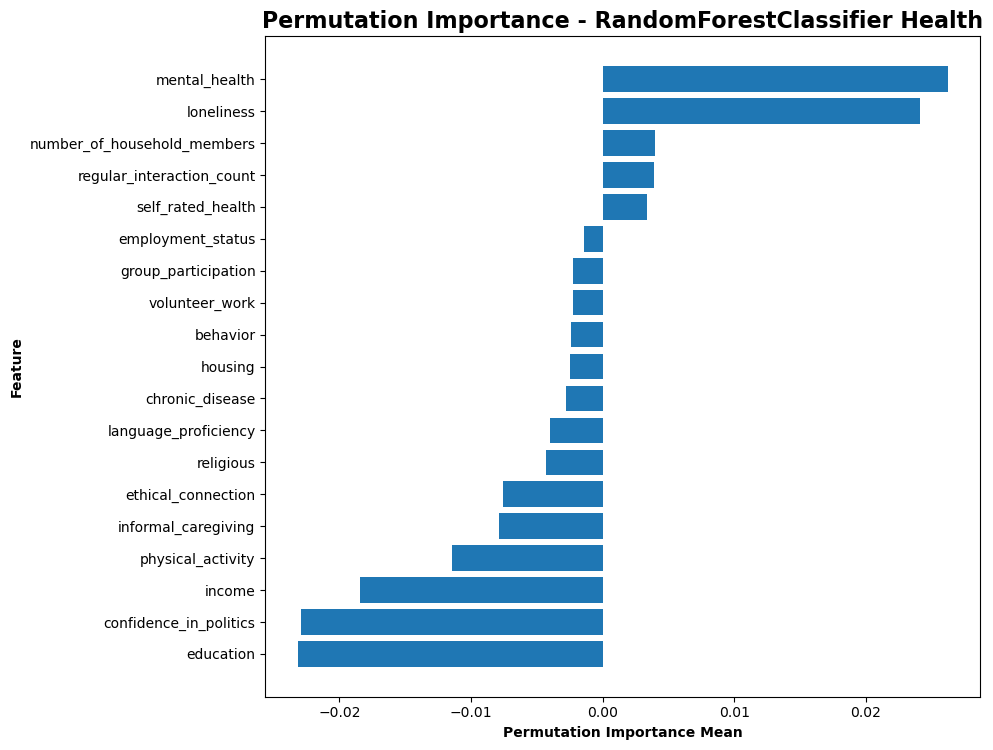


Calculating permutation importance for CatBoostClassifier Health...


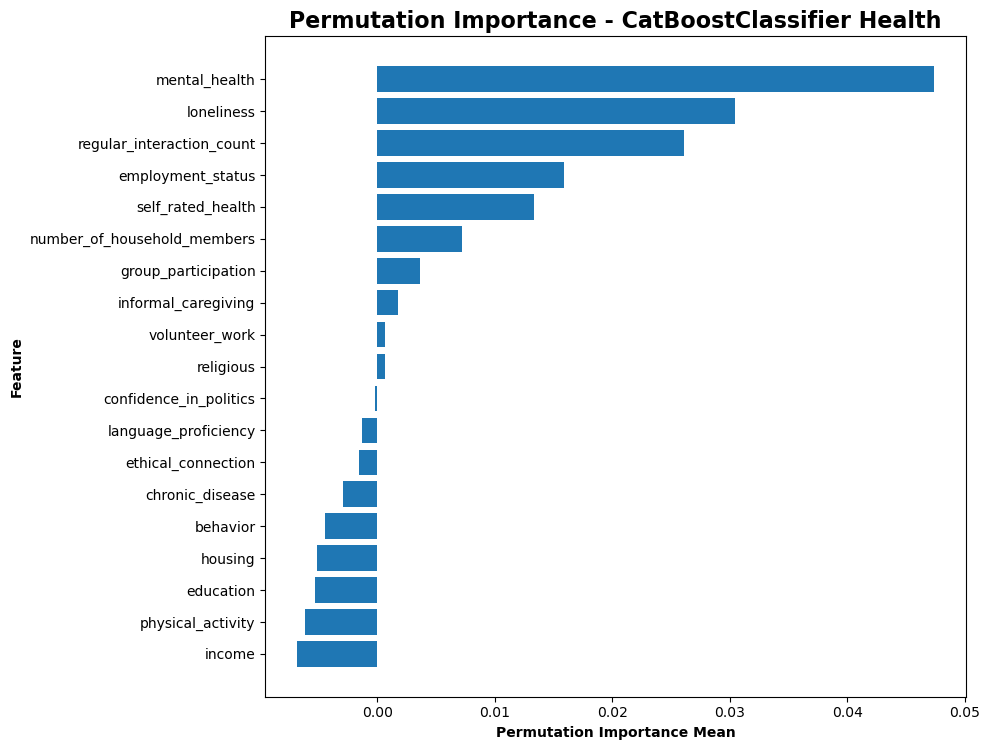


Calculating permutation importance for SVC Health...


/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/kevinduquesnoy/anaconda3/lib/python3.11/site-packages/skle

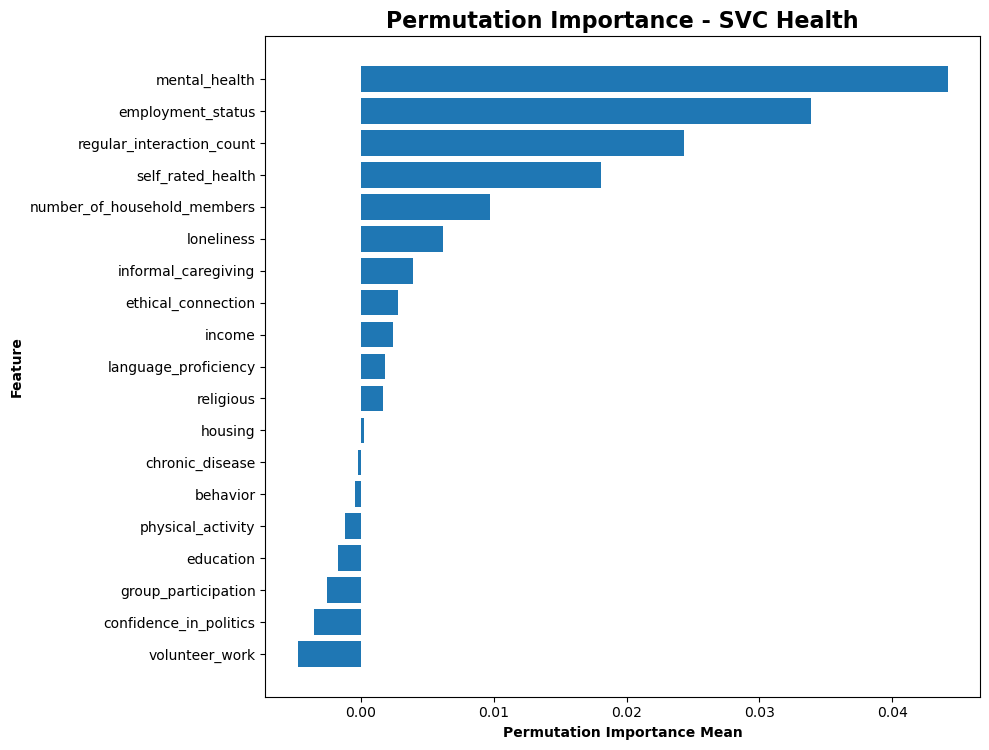


Calculating permutation importance for AdversarialFairnessClassifier Health...


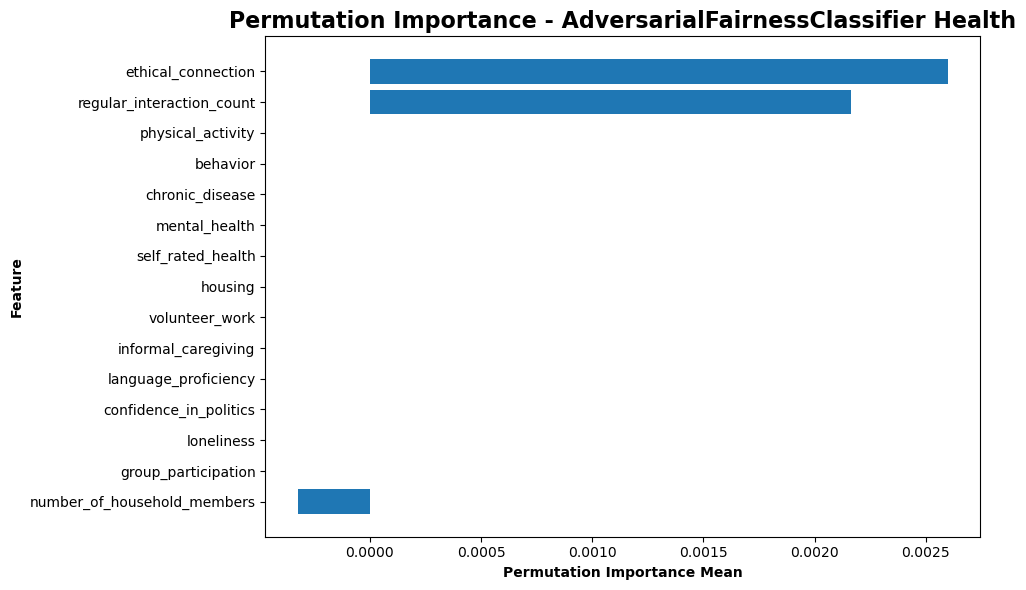

In [66]:
# Feature importance
# Permutation importance of features per model


# plot permutation importance for each model
plot_permutation_importance(rf_clf_health, X_test_health_scaled, y_test_health, X_test_health_scaled.columns, 'RandomForestClassifier Health')
plot_permutation_importance(catboost_clf_health, X_test_health_scaled, y_test_health, X_test_health_scaled.columns, 'CatBoostClassifier Health')
plot_permutation_importance(svm_clf_health, X_test_health_scaled, y_test_health, X_test_health_scaled.columns, 'SVC Health')
plot_permutation_importance(final_AFC_model_health, X_main_holdout_test_health, y_holdout_test_health, X_main_holdout_test_health.columns, 'AdversarialFairnessClassifier Health')


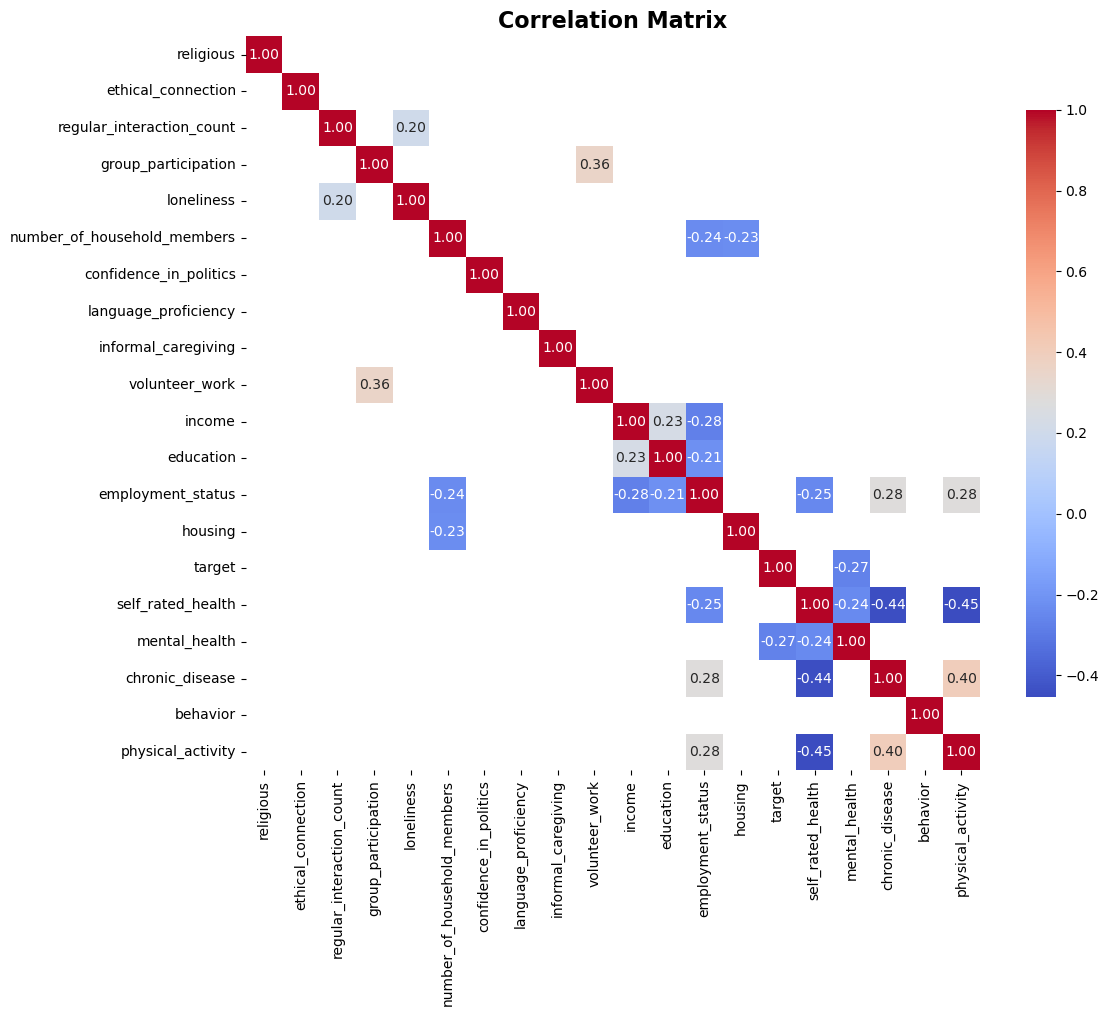

In [61]:
# check feature correlation


# correlation matrix
correlation_matrix_health = health_dataset.corr()
#creating a filtered correlation matrix for values in the upper and lower 20% of correlation values
threshold = 0.2
mask = (correlation_matrix_health > threshold) | (correlation_matrix_health < -threshold)
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_health[mask], annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Health', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


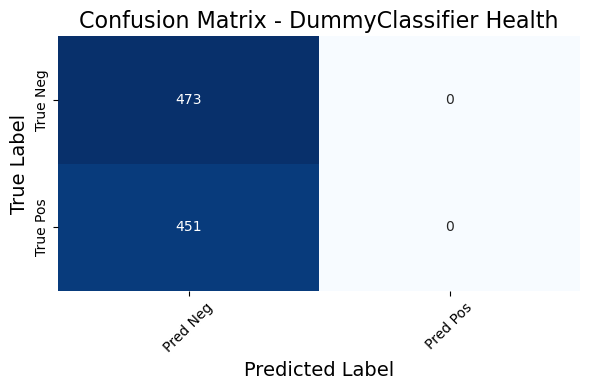

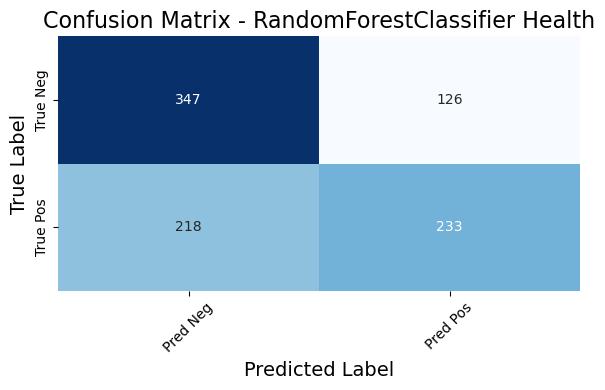

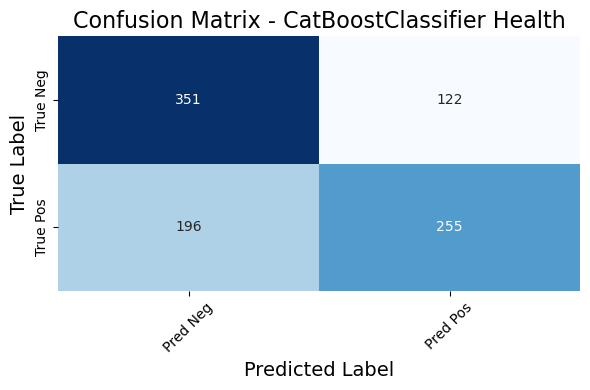

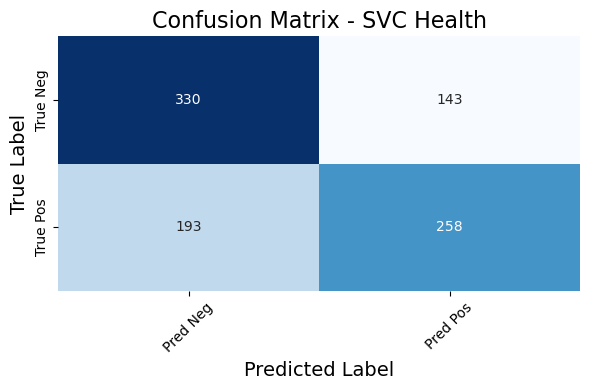

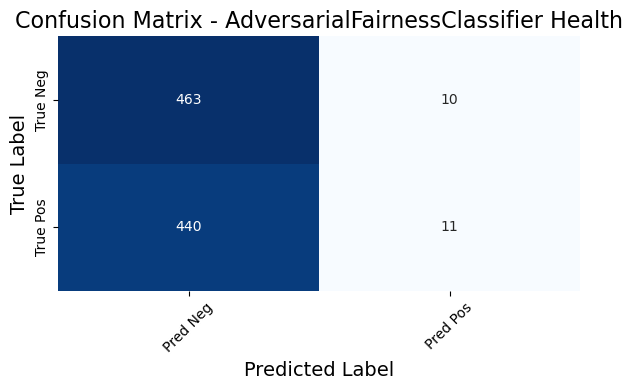

In [65]:
# Generating confusion matrices for all model predictions


# plot confusion matrices for all models
plot_confusion_matrix(y_test_health, dummy_clf_health.predict(X_test_health_scaled), 'DummyClassifier Health')
plot_confusion_matrix(y_test_health, rf_clf_health.predict(X_test_health_scaled), 'RandomForestClassifier Health')
plot_confusion_matrix(y_test_health, catboost_clf_health.predict(X_test_health_scaled), 'CatBoostClassifier Health')
plot_confusion_matrix(y_test_health, svm_clf_health.predict(X_test_health_scaled), 'SVC Health')
plot_confusion_matrix(y_holdout_test_health, final_AFC_model_health.predict(X_main_holdout_test_scaled_np_health), 'AdversarialFairnessClassifier Health')
